# Practice Session 03: Find near-duplicates using shingling

Author: <font color="blue">Miguel Rando Ramirez</font>

E-mail: <font color="blue">miguelrando14@gmail.com</font>

Date: <font color="blue">8/10/24</font>

In [2]:
import io
import json
import gzip
import re
import random
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer

import datetime

In [3]:
# KEEP AS-IS

# Input file
INPUT_FILENAME = "CovidLockdownCatalonia.json.gz"

# Array for storing messages
messages = []

# IMPORTANT:
# 1. Set this to 1000 during development
# 2. Set this to 10000 once you have completed the development, and answer part 5 with 10000
# 3. Set this back to 1000 for delivering your code
MAX_MESSAGES = 1000

with gzip.open(INPUT_FILENAME, "rt", encoding="utf-8") as input_file:
    
    messages_read = 0
    for line in input_file:
            
        # Read message
        tweet = json.loads(line)

        # Keep only messages in Catalan
        if tweet["lang"] == "ca":
            
            messages_read += 1
            
            if messages_read <= MAX_MESSAGES:
                author = tweet["user"]["screen_name"]
                message = tweet["full_text"]
                messages.append(message)

print("Read %d documents" % len(messages))

Read 10000 documents


# 1. Auxiliary functions

<font size="+1" color="red">Replace this cell with your code for function "jaccard_similarity"</font>

In [4]:
def jaccard_similarity(l1, l2):
    
    s1 = set(l1)
    s2 = set(l2)
    
    union = s1.union(s2)
    intersection = s1.intersection(s2)
    
    # vemos si la unión está vacía para evitar ZeroDivisionError
    if len(union) == 0:
        return 0.0  # si ambos conjuntos están vacíos retornamos 0.0
    
    jaccard = len(intersection)/len(union)
    
    return jaccard
    

<font size="+1" color="red">Replace this cell with your code testing "jaccard_similarity"</font>

In [5]:
array1 = ['hola', 'me', 'llamo', 'Miguel']
array2 = ['hola', 'Miguel']
array3 = ['hola', 'me', 'llamo']
array4= ['adios']
array5 = ['hola', 'me', 'llamo', 'Miguel']




print(jaccard_similarity(array1, array2))
print(jaccard_similarity(array1, array3))
print(jaccard_similarity(array1, array4))
print(jaccard_similarity(array1, array5))

0.5
0.75
0.0
1.0


<font size="+1" color="red">Replace this cell with your code for function "clean"</font>

In [6]:
from unidecode import unidecode
def clean(text):
    text = re.sub(r'\bRT\b', '', text)
    
    text = text.lower()

    text = re.sub(r'Ñ', 'n', text)
    text = re.sub(r'ñ', 'n', text)
    text = re.sub(r'ó', 'o', text)
    text = re.sub(r'à', 'a', text)
    text = re.sub(r'l·l', 'll', text)   
    
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'https\S+', '', text)
    
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    
    text = text.strip()
    
    text = re.sub(r'\s+', ' ', text)


    return text
    

<font size="+1" color="red">Replace this cell with your code testing function "clean"</font>

In [7]:
text1 = "RT ¡Hola! Me llamo Miguel, visítame en https://example.com o llámame mañana."
cleaned_text1 = clean(text1)
print(cleaned_text1)

text2 = "Buenos días, cómo estás? Yo   estoy bien, ¡gracias!"
cleaned_text2 = clean(text2)
print(cleaned_text2) 

text3 = "Visita http://mywebsite.com o https://anotherpage.com y disfruta! ¡Hasta luego, señor!"
cleaned_text3 = clean(text3)
print(cleaned_text3) 

text4 = "¡No entiendo! ¿Qué significa 'l·l' en catalán? 100% seguro que es una letra."
cleaned_text4 = clean(text4)
print(cleaned_text4)

text5 = "Llamaré al número 123-456-7890 mañana... ¡espero!    "
cleaned_text5 = clean(text5)
print(cleaned_text5)


hola me llamo miguel vistame en o llmame manana
buenos das como ests yo estoy bien gracias
visita o y disfruta hasta luego senor
no entiendo qu significa ll en cataln 100 seguro que es una letra
llamar al nmero 1234567890 manana espero


# 2. Implement an n-gram extractor

<font size="+1" color="red">Replace this cell with your code implementing function "ngrams(text,size)"</font>

In [8]:
MIN_TOKEN_LENGTH = 3

def ngrams(text, size):
    tokens = clean(text).split()  
    ngrams = []  
    
    # filtrar las palabras con al menos MIN_TOKEN_LENGTH caracteres
    tokens = [word for word in tokens if len(word) >= MIN_TOKEN_LENGTH]

    # generar los n-grams 
    for i in range(len(tokens) - size + 1):
        ngrams.append(' '.join(tokens[i:i + size]))

    return ngrams

<font size="+1" color="red">Replace this cell with your code testing function "ngrams"</font>

In [9]:
print(messages[990])
print(ngrams(messages[990], 3))

Clam per la suspensió dels desnonaments en plena crisi pel coronavirus https://t.co/0g1AtSELwl
['clam per suspensio', 'per suspensio dels', 'suspensio dels desnonaments', 'dels desnonaments plena', 'desnonaments plena crisi', 'plena crisi pel', 'crisi pel coronavirus']


# 3. Estimation of brute force all-pairs method

In [49]:
# LEAVE AS-IS

def time_brute_force_similarities(messages, limit, ngram_size):
    if limit > len(messages):
        raise ValueError("Limit should be less than or equal than the number of messages")
        
    # Start a timer
    start = timer()

    # Iterate through document identifiers
    for docid1 in range(np.min([len(messages), limit])):

        # Clean document 1 and extract ngrams
        doc1 = clean(messages[docid1])
        ngrams1 = ngrams(doc1, ngram_size)

        # Iterate through document identifiers larger than doc2
        for docid2 in range(docid1+1, np.min([len(messages), limit])):
                         
            # Clean document 2 and extract ngrams
            doc2 = clean(messages[docid2])
            ngrams2 = ngrams(doc2, ngram_size)

            # Compute similarity
            similarity = jaccard_similarity(ngrams1, ngrams2)

    end = timer()
    return(end - start)

<font size="+1" color="red">Replace this cell with your code for generating the requested plot. Remember to add a title and label for the x and y axis.</font>

In [10]:
%matplotlib inline


[0.0014161020000074132, 1.0047564739999757, 3.6331996950000303, 7.901694849000023, 14.130881159000012]


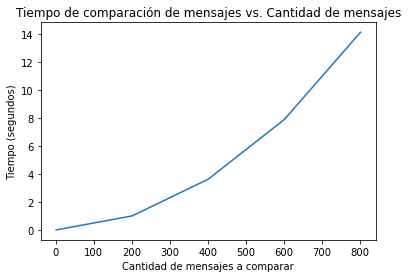

In [12]:
# de 1 a 1001 incrementos de 200
limits = range(1, 1001, 200)
times = []  # Lista para almacenar los tiempos

# calculamos el tiempo para cada límite de mensajes
for limit in limits:
    t = time_brute_force_similarities(messages, limit, ngram_size=5)
    times.append(t)

plt.plot(limits, times)

# Añadimos título y etiquetas a los ejes
plt.title('Tiempo de comparación de mensajes vs. Cantidad de mensajes')
plt.xlabel('Cantidad de mensajes a comparar')
plt.ylabel('Tiempo (segundos)')

plt.show()


<font size="+1" color="red">Replace this cell with (1) a brief commmentary about what you see in this plot, and (2) your estimate for how long it would take to run the brute force similarity computations for the entire input matrix. Express your estimation in hours, minutes, and seconds. Justify precisely your calculations.</font>

We can see that the increment of the time is exponential. I dont know how to calculate the time for 35.500 messages, but be can see that in each step of 200 messages the times encreases the double more or less. So we will need 178 steps (aprox), then they are 174 steps left. Then we do 14 x (2^174) = 3.35 x 10^53 secs. wich would be 9.31 x 10^49 h (aprox).

I dont know if the computation is okay.

# 4. Computing the doc-ngram matrix

Now we will compute a matrix in which every row is an ngram, and every column is a document.

In real-world implementations, this is done by hashing the ngrams and then every row is an ngram *hash*; in this practice we will skip that step and work directly with one ngram per row, which is conceptually the same and easier to code.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

## 4.1 Create list of all ngrams

Implement code to create:

* the dictionary `ngram_to_index`, which should convert an ngram to an index (a row number),
* the dictionary `index_to_ngram`, which should convert an index to an ngram, and
* the variable `num_distinct_ngrams` which should contain the number of distinct ngrams.

You can use the following template:

```python
NGRAM_SIZE = 4

ngram_to_index = {}
index_to_ngram = {}
next_index = 0

for message in messages:
    all_ngrams = ngrams(message, NGRAM_SIZE)
    for ngram in all_ngrams:
        # YOUR CODE HERE
            
num_distinct_ngrams = next_index

print("There are %d distinct ngrams in the %d documents" % (num_distinct_ngrams, len(messages)))
```

Note that the total number of n-grams may vary depending on ho you `clean()` text. In this dataset it should be about 10 times the number of documents.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code for creating the ngram_to_index dictionary.</font>

In [10]:
NGRAM_SIZE = 4

ngram_to_index = {}
index_to_ngram = {}
next_index = 0

for message in messages:
    all_ngrams = ngrams(message, NGRAM_SIZE) 
    for ngram in all_ngrams:
        if ngram not in ngram_to_index:  
            ngram_to_index[ngram] = next_index  # si el n-gram no estaba en el diccionario, se añade
            index_to_ngram[next_index] = ngram  #se guarda tambien de forma inversa
            next_index += 1  

num_distinct_ngrams = next_index

# Output the result
print("There are %d distinct ngrams in the %d documents" % (num_distinct_ngrams, len(messages)))

There are 54083 distinct ngrams in the 10000 documents


Test your function by printing the `ngram_to_index` of the strings `els restaurants han reduir` and `supera fins tot mateix`. The exact index varies,  depending on how you `clean()` text. What is important is that when you print the `index_to_ngram` of the returned index, it should give you the same string. 

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code for testing the ngram_to_index structure.</font>

In [11]:
# Definir el texto para probar
test_strings = [
    "els restaurants han reduir",
    "supera fins tot mateix"
]

# limpiar 
cleaned_test_strings = [clean(s) for s in test_strings]  

# obtener los n-gramas de los strings limpios
for cleaned_string in cleaned_test_strings:
    ngrams_list = ngrams(cleaned_string, NGRAM_SIZE)
    
    for ngram in ngrams_list:
        if ngram in ngram_to_index:
            index = ngram_to_index[ngram]
            # Imprimir el n-grama, su índice y el n-grama recuperado usando index_to_ngram
            retrieved_ngram = index_to_ngram[index]
            print(f"N-grama: '{ngram}', Índice: {index}, N-grama recuperado: '{retrieved_ngram}'")

N-grama: 'els restaurants han reduir', Índice: 14, N-grama recuperado: 'els restaurants han reduir'
N-grama: 'supera fins tot mateix', Índice: 36, N-grama recuperado: 'supera fins tot mateix'


## 2.2 Create table ngrams x documents

Now we will create a boolean matrix named `M_ngram_doc`, where each row should be an n-gram, and each column should be a document.

There might be documents having less than *NGRAM_SIZE* words and thus containing no shingles. You can skip those documents above (when reading the file), or handle them here.

The next code creates an empty matrix. Leave as-is. If you run out of memory, limit the number of documents you read at the beginning of this file, for instance, read only the first 10,000 or the first 7,000 documents, and then try again.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [12]:
# LEAVE AS-IS

# Create dense matrix in which every cell contains the value "False"
M_ngram_doc = np.full((num_distinct_ngrams, len(messages)), False)

# Print the number of rows and columns of this matrix
# numpy.matrix.shape is a tuple, shape[0] is the number of rows, shape[1] the number of columns
print("Matrix dimensions: %d rows (distinct shingles) x %d columns (distinct documents)" % M_ngram_doc.shape)

Matrix dimensions: 54083 rows (distinct shingles) x 10000 columns (distinct documents)


Complete the matrix `M_ngram_doc` so that position i, j (row, column) holds a `True` if document j contains ngram i, otherwise holds `False`.

You can use the following template:

```python
for docid in range(len(messages)):
    message = messages[docid]
    all_ngrams = ngrams(message, ngram_size)
    for ngram in all_ngrams:
        # replace this comment with your code
```

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code for filling the M_ngram_doc matrix.</font>

In [13]:
for docid in range(len(messages)):
    message = messages[docid]
    all_ngrams = ngrams(message, NGRAM_SIZE)
    for ngram in all_ngrams:
        if ngram in ngram_to_index:
            index = ngram_to_index[ngram]  # get the index for the n-gram
            M_ngram_doc[index, docid] = True  # Set the matrix cell to True

Measure the density of this matrix, as a percentage. This is the number of non-zeroes in the matrix as a percentage of the number of cells of the matrix.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code for printing the density of the M_ngram_doc matrix as a percentage. Use 4 decimals.</font>

In [14]:
# count the number of non-zero entries (True values)
num_non_zero_entries = np.count_nonzero(M_ngram_doc)

# calculate total number of entries in the matrix
total_entries = M_ngram_doc.shape[0] * M_ngram_doc.shape[1]

# calculate the  percentage
density_percentage = (num_non_zero_entries / total_entries) * 100

print(f"Density of the matrix: {density_percentage:.4f}%")

Density of the matrix: 0.0203%


Print a couple of documents (columns). All columns should be very sparse, i.e., mostly zeroes. For instance, for docid 9602 you should print something like this:

```
Positions of non-zeros in column of docid 16 of M_ngram_doc

Clean message:
 emergenciescat es demana a la ciutadania limitar al maxim i si es pot evitar desplaaments de cap de setmana tot el que sigui ma

Non-zeros in corresponding row:
 ['177 (emergenciescat demana ciutadania limitar)', '178 (demana ciutadania limitar maxim)', '179 (ciutadania limitar maxim pot)', '180 (limitar maxim pot evitar)', '181 (maxim pot evitar desplaaments)', '182 (pot evitar desplaaments cap)', '183 (evitar desplaaments cap setmana)', '184 (desplaaments cap setmana tot)', '185 (cap setmana tot que)', '186 (setmana tot que sigui)']
 ```

Note that the specific ngram ids you will get depend on your cleanup process, and that the output is in ascending order of ngram number, not in the same ordering in which the ngrams appear in the message.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code for printing rows 9602 and 941 of the M_ngram_doc matrix.</font>

In [15]:
doc_ids_to_print = [9602, 941] 

for docid in doc_ids_to_print:
    # Extract the cleaned message for the document
    message = messages[docid]  # Get the original message
    cleaned_message = clean(message)  # Clean the message

    # Find the non-zero positions in the corresponding column of M_ngram_doc
    non_zero_indices = np.where(M_ngram_doc[:, docid])[0]  # Get indices of True values

    # Gather the corresponding n-grams
    non_zero_ngrams = [f"{index} ({index_to_ngram[index]})" for index in non_zero_indices]

    # Print results
    print(f"Positions of non-zeros in column of docid {docid} of M_ngram_doc\n")
    print("Clean message:")
    print(cleaned_message)
    print("\nNon-zeros in corresponding row:")
    print(non_zero_ngrams)


Positions of non-zeros in column of docid 9602 of M_ngram_doc

Clean message:
emergenciescat qu puc fer i que no faqs del coronavirus a 14 de mar si us plau demanem difusio

Non-zeros in corresponding row:
['31120 (emergenciescat puc fer que)', '31121 (puc fer que faqs)', '31122 (fer que faqs del)', '31123 (que faqs del coronavirus)', '31124 (faqs del coronavirus mar)', '31125 (del coronavirus mar plau)', '31126 (coronavirus mar plau demanem)', '31127 (mar plau demanem difusio)']
Positions of non-zeros in column of docid 941 of M_ngram_doc

Clean message:
hospiolot usem de forma responsable els recursos sanitaris 061 urgncies per coronavirus i sanitaries 012 consultes general

Non-zeros in corresponding row:
['1052 (usem forma responsable els)', '1053 (forma responsable els recursos)', '1054 (responsable els recursos sanitaris)', '1055 (els recursos sanitaris 061)', '1056 (recursos sanitaris 061 urgncies)', '1057 (sanitaris 061 urgncies per)', '1058 (061 urgncies per coronavirus)', '10

# 3. Implement a permutation generator

Implement the function `random_permutation(k)`, which should generate a random permutation of the array `[0, 2, 3, ..., k-1]`. Tip: the function [random.shuffle](https://docs.python.org/3/library/random.html#random.shuffle) might be useful. If you want to use `range(...)`, which returns an iterator, you will need to convert the iterator to a list by using `list(range(...))`.

Remember to test your code. For instance, a permutation of 20 elements should look like this:

```
[14, 10, 0, 8, 4, 12, 5, 19, 6, 9, 15, 13, 16, 2, 17, 11, 7, 3, 18, 1]
```

Every number appears only once, and all numbers from 0 to 19 appear in the permutation.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code for "random_permutation"</font>

In [16]:
import random

def random_permutation(k):
    arr = list(range(k))     # create a list with numbers from 0 to k-1
    random.shuffle(arr)
    return arr


In [17]:
# Test the function
k = 20
permutation = random_permutation(k)

print("Random permutation of length", k, ":", permutation)



Random permutation of length 20 : [3, 4, 5, 13, 7, 11, 6, 18, 2, 8, 10, 0, 12, 16, 17, 15, 14, 19, 9, 1]


Further test this by applying the same permutation on two lists. The code below, which you must leave as-is,  should print both lists in the same ordering, so that *alpha* is in the same position of *a*, *beta* in the same position as *b*, and so on.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [18]:
# LEAVE AS-IS

# Permute a list according to a permutation
def permuter(original_list, permutation):
    permuted_list = []
    for index in permutation:
        permuted_list.append(original_list[index])
    return permuted_list

# Code for testing permutations
original_list_1 = ["1 (test1)", "2 (test2)", "3 (test3)", "4 (test4)", "5 (test5)"]
original_list_2 = ["1 (alpha)", "2 (gamma)", "3 (beta)", "4 (delta)", "5 (epsilon)"]

print("Test one permutation:")
permutation_1 = random_permutation(5)
print(permuter(original_list_1, permutation_1))
print(permuter(original_list_2, permutation_1))

print()

print("Test another permutation")
permutation_2 = random_permutation(5)
print(permuter(original_list_1, permutation_2))
print(permuter(original_list_2, permutation_2))

Test one permutation:
['4 (test4)', '2 (test2)', '3 (test3)', '5 (test5)', '1 (test1)']
['4 (delta)', '2 (gamma)', '3 (beta)', '5 (epsilon)', '1 (alpha)']

Test another permutation
['2 (test2)', '5 (test5)', '3 (test3)', '4 (test4)', '1 (test1)']
['2 (gamma)', '5 (epsilon)', '3 (beta)', '4 (delta)', '1 (alpha)']


# 4. Compute the signature of each document

Now comes the core of the algorithm. We will create a new matrix `M_signature_doc` having a small number of rows (the *signature size*), which will be equivalent to the number of permutations we use. The number of columns will continue being the number of documents.

First, we create the permutations and store them in an array of arrays named `permutations`, with the following code, which you should leave as-is.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [19]:
# Leave this code as-is

NUM_PERMUTATIONS = 5

permutations = []

# Create the permutations
for i in range(NUM_PERMUTATIONS):
    permutation = random_permutation(num_distinct_ngrams)
    permutations.append(random_permutation(num_distinct_ngrams))
    
# Visualize the permutations by printing their first 4 elements
for i in range(len(permutations)):
    permutation = permutations[i]
    print("Permutation %d: %d, %d, %d, %d, ..." % (i,
                permutation[0], permutation[1], permutation[2], permutation[3] ))

Permutation 0: 27939, 39412, 42070, 41193, ...
Permutation 1: 10686, 6494, 52320, 31859, ...
Permutation 2: 41341, 10766, 36928, 25695, ...
Permutation 3: 48455, 34406, 28217, 29888, ...
Permutation 4: 26631, 53815, 28757, 814, ...


Now, you implement the signature construction. The matrix `M_signature_doc` should contain in row *i*, column *j*, the first ngram (the "minimum" one) that is present in a column (document), according to the order given by a permutation.

This process may take a few minutes to be completed. You can use the following template:

```python
M_signature_doc = np.full((NUM_PERMUTATIONS, len(messages)), np.nan)

# Create permutations
for permutation_num in range(NUM_PERMUTATIONS):
    print("Creating signatures for permutation %d/%d" % (permutation_num+1, NUM_PERMUTATIONS))
    permutation = permutations[permutation_num]
    for docid in range(len(messages)):
        if docid % 1000 == 0:
            print("- Scanning document %d of %d" % (docid, len(messages)))
        # replace this comment with your code
```

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

The following function, which you should leave as-is, finds the first n-gram that appears in a document, according to the ordering defined by a permutation.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [20]:
# LEAVE AS-IS

# Find the first ngram in a document, according to a permutation
def find_first_one(docid, permutation):
    for shingle_id in permutation:
        if M_ngram_doc[shingle_id, docid] == True:
            return shingle_id
    return -1

<font size="+1" color="red">Replace this cell with your code for creating M_signature_doc</font>

In [21]:
M_signature_doc = np.full((NUM_PERMUTATIONS, len(messages)), np.nan)

# Loop through each permutation
for permutation_num in range(NUM_PERMUTATIONS):
    print("Creating signatures for permutation %d/%d" % (permutation_num + 1, NUM_PERMUTATIONS))
    permutation = permutations[permutation_num]

    # Loop through each document
    for docid in range(len(messages)):
        if docid % 1000 == 0:
            print("- Scanning document %d of %d" % (docid, len(messages)))
        
        # Find the first n-gram for this document according to the permutation
        first_ngram_id = find_first_one(docid, permutation)
        M_signature_doc[permutation_num, docid] = first_ngram_id

# Print the dimensions of the signature matrix
print("Signature matrix dimensions: %d rows (permutations) x %d columns (documents)" % M_signature_doc.shape)

Creating signatures for permutation 1/5
- Scanning document 0 of 10000
- Scanning document 1000 of 10000
- Scanning document 2000 of 10000
- Scanning document 3000 of 10000
- Scanning document 4000 of 10000
- Scanning document 5000 of 10000
- Scanning document 6000 of 10000
- Scanning document 7000 of 10000
- Scanning document 8000 of 10000
- Scanning document 9000 of 10000
Creating signatures for permutation 2/5
- Scanning document 0 of 10000
- Scanning document 1000 of 10000
- Scanning document 2000 of 10000
- Scanning document 3000 of 10000
- Scanning document 4000 of 10000
- Scanning document 5000 of 10000
- Scanning document 6000 of 10000
- Scanning document 7000 of 10000
- Scanning document 8000 of 10000
- Scanning document 9000 of 10000
Creating signatures for permutation 3/5
- Scanning document 0 of 10000
- Scanning document 1000 of 10000
- Scanning document 2000 of 10000
- Scanning document 3000 of 10000
- Scanning document 4000 of 10000
- Scanning document 5000 of 10000
- Sca

Test your code by checking the signatures of two documents that are near-duplicates,using the next code, which you should leave as-is. Being near-duplicates, we expect these should have many ngrams in common, and hence, with high probability they will have many elements in common in their signatures.

Note that your ngrams and signatures vectors might be different than what we show here, given the differences in cleaning procedures and the randomness of the permutations.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [22]:
# Leave this code as-is

def extract_ngrams(docid):
    return [x for x in range(num_distinct_ngrams) if M_ngram_doc[x, docid] == True]

def extract_signature(docid):
    return [M_signature_doc[x, docid] for x in range(NUM_PERMUTATIONS)]

def print_sig(messages, M_ngram_doc, M_signature_doc, i):
    print("Document #%d" % i)
    print("Message       : %s" % messages[i])
    print("Clean message : %s" % clean(messages[i]))
    print("Ngrams        : %s" % extract_ngrams(i))
    print("Signature     : %s" % extract_signature(i))

# Print two messages and their signatures

print_sig(messages, M_ngram_doc, M_signature_doc, 21 )
print()
print_sig(messages, M_ngram_doc, M_signature_doc, 24 )

Document #21
Message       : El problema és económic... ja no és només que primi lo económic a lo personal, és que fins i tot en això el @govern s'equivoca, doncs al final la factura que s'haurà de pagar serà més gran.... ja és més gran del que hauria sigut de fer les coses bé i a temps. https://t.co/jFXHAMZHO0
Clean message : el problema s economic ja no s noms que primi lo economic a lo personal s que fins i tot en aix el govern sequivoca doncs al final la factura que shaura de pagar sera ms gran ja s ms gran del que hauria sigut de fer les coses b i a temps
Ngrams        : [228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254]
Signature     : [234.0, 241.0, 242.0, 228.0, 231.0]

Document #24
Message       : RT @QuimTorraiPla: Seguiu les recomanacions: eviteu qualsevol desplaçament al màxim
Clean message : quimtorraipla seguiu les recomanacions eviteu qualsevol desplaament al maxim
Ngrams        : [274, 

# 5. Compare all pairs of signatures

Now we are ready to compare all documents by their signatures, instead of by their content.

We will consider that if two documents have *similarity == 1.0* they are a *full signature match*, and if two documents have *0.2 < similarity < 1.0* they are a *partial signature match*. In both cases, this may mean the documents are duplicates or near duplicates.

Write code to compare all pairs of documents. Use the following template:

```python
is_possible_duplicate = {}

# Iterate through all documents
for docid1 in range(len(messages)):

     # Do not examine again a document that is a possible duplicate
    if docid not in is_possible_duplicate:

        # Counters for full and partial signature matches
        count_sig_full_matches = 0
        count_sig_partial_matches = 0

        # Extract the signature of the doc1
        signature1 = extract_signature(docid1)
        if docid1 % 500 == 0:
            print("%d/%d documents scanned" % (docid1, len(messages)))

        # Iterate through documents with docid larger than doc1
        for docid2 in range(docid1+1, len(messages)):

            # If this has not already been marked as duplicate of another document
            if docid2 not in is_possible_duplicate:

                # Extract signature of doc2
                signature2 = extract_signature(docid2)

                # REPLACE THIS COMMENT WITH YOUR CODE:
                # - Increase count_sig_full_matches and count_sig_partial_matches as needed
                # - Include docid2 in is_possible_duplicate if needed

        # REPLACE THIS COMMENT WITH YOUR CODE
        # - If the number of partial matches plus full matches exceeds a threshold
        #   print the document doc1 and indicate how many matches of each type it has
```

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code for comparing all signatures; print all documents that have at least X signature matches, considering both full matches and partial matches. X should be 0.5% of the  number of documents.</font>

In [23]:
is_possible_duplicate = {}

X = int(0.005 * len(messages))  # Calculate 0.5% of the total number of documents

for docid1 in range(len(messages)):
    # Do not examine again a document that is a possible duplicate
    if docid1 not in is_possible_duplicate:
        
        # Counters for full and partial signature matches
        count_sig_full_matches = 0
        count_sig_partial_matches = 0

        # Extract the signature of the doc1
        signature1 = extract_signature(docid1)
        if docid1 % 500 == 0:
            print("%d/%d documents scanned" % (docid1, len(messages)))

        # Iterate through documents with docid larger than doc1
        for docid2 in range(docid1 + 1, len(messages)):
            
            # If this has not already been marked as duplicate of another document
            if docid2 not in is_possible_duplicate:
                
                # Extract signature of doc2
                signature2 = extract_signature(docid2)

                # Compute similarity between signatures
                similarity = jaccard_similarity(signature1, signature2)


                # Increase count_sig_full_matches and count_sig_partial_matches as needed
                if similarity == 1.0:
                    count_sig_full_matches += 1
                    is_possible_duplicate[docid2] = True  # Mark as duplicate
                elif 0.2 < similarity < 1.0:
                    count_sig_partial_matches += 1
                    is_possible_duplicate[docid2] = True  # Mark as duplicate

        # Check if the number of matches exceeds the threshold X
        total_matches = count_sig_full_matches + count_sig_partial_matches
        if total_matches >= X:  # If total matches exceed the threshold
            print(f"Document {docid1} has {count_sig_full_matches} full matches and {count_sig_partial_matches} partial matches.")



0/10000 documents scanned
Document 16 has 71 full matches and 0 partial matches.
Document 53 has 57 full matches and 0 partial matches.
Document 73 has 17 full matches and 34 partial matches.
Document 83 has 128 full matches and 0 partial matches.
Document 166 has 56 full matches and 0 partial matches.
Document 328 has 65 full matches and 0 partial matches.
500/10000 documents scanned
1000/10000 documents scanned
2000/10000 documents scanned
4000/10000 documents scanned
4500/10000 documents scanned
5000/10000 documents scanned
Document 5077 has 176 full matches and 0 partial matches.
Document 5109 has 66 full matches and 0 partial matches.
Document 5117 has 71 full matches and 0 partial matches.
Document 5129 has 54 full matches and 0 partial matches.
Document 5271 has 54 full matches and 0 partial matches.
5500/10000 documents scanned
Document 5636 has 80 full matches and 0 partial matches.
7500/10000 documents scanned


<font size="+1" color="red">Replace this cell with a brief commentary, based on the results above, about one tweet that has a substantial number of complete matches, but few partial matches. Include the full text of the original tweet. Comment on why you believe this tweet is not being changed much when copied or re-tweeted.</font>

I have obtained that document 5077 has 176 full matches, the most number of full matches obtained. This is the tweet:

''RT @emergenciescat: Què puc fer i que no? FAQs del #coronavirus a 14 de març. si us plau, demanem difusió. https://t.co/D5HNxwYjwK''

It has a lot of full matches because it is a message of the emergencies of catalunya, with very important information on what is allowed to do, so people copy it literally and resend it. Also it has a lot of copies because the tweet by itself is asking to be spread.


<font size="+1" color="red">Replace this cell with a brief commentary, based on the results above, about one tweet that has a substantial number of partial matches, but fewer complete matches. Include the full text of the original tweet and one near duplicate (that cannot be identical to the original tweet).</font>

The only one that has more partial matches than full matches is document 73, with 34 partial matches. This is the tweet:

''RT @VilaWeb: [VÍDEO] Ortega Smith passejant per Madrid sense mascareta i amb la seva mare després del positiu de coronavirus https://t.co/M…''

This has more partial matches because it is a new about a controversy topic, so it is easier to the people to change some words, or to add some information, but basicly they talk about the same.
This is an example of a partial match (document 3590):

''RT @vpartal: [VÍDEO] Ortega Smith passejant per Madrid sense màscara i amb la seva mare tot i tenir el coronavirus https://t.co/lNvPS4Qs0C''

# DELIVER (individually)

Remember to read the section on "delivering your code" in the [course evaluation guidelines](https://github.com/chatox/data-mining-course/blob/master/upf/upf-evaluation.md).

Deliver a zip file containing:

* This notebook

## Extra points available

For more learning and extra points, compare what happens with 3 different ngram sizes (2-grams, 3-grams, 4-grams) in terms of the efficiency (speed) and effectiveness (accuracy). You can include plots for efficiency, and examples for effectiveness.

**Note:** if you go for the extra points, add ``<font size="+2" color="blue">Additional results: various ngram sizes</font>`` at the top of your notebook.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+2" color="#003300">I hereby declare that, except for the code provided by the course instructors, all of my code, report, and figures were produced by myself.</font>